# Imports

In [ ]:
import math
import pandas as pd
import numpy as np
import madmom as mm
import librosa as lr
import pretty_midi as pm
import librosa.display as display
import IPython.display as ipd
import matplotlib.pyplot as plt

# Constants

In [35]:
DATAPOINT = "../datasets/maps/CH/" + \
            "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
MIDI_DATAPOINT = "../datasets/maps/CH/" + \
        "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"

# DATAPOINT = "../datasets/maps/C0-1-3-4-8/" + \
#             "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.wav"
# MIDI_DATAPOINT = "../datasets/maps/C0-1-3-4-8/" + \
#         "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.mid"

# Wrangle Data
(load datapoint)

In [36]:
timeSeries, sampleRate = lr.load(DATAPOINT)

In [37]:
sampleRate

22050

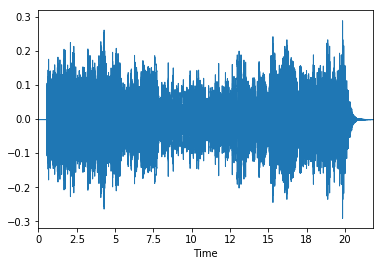

In [38]:
display.waveplot(timeSeries, sr=sampleRate)

In [39]:
ipd.Audio(timeSeries, rate=sampleRate)

# Spectrogramify

### CQT Form

In [40]:
cqtSpect = lr.cqt(timeSeries,
                  fmin=lr.midi_to_hz(21),
                  sr=sampleRate,
                  hop_length=512,
                  bins_per_octave=16, # "resolution within an 8ve"
                  n_bins=16 * 8)      # number of total bins
                 

In [41]:
cqtSpect.T.shape

(942, 128)

In [42]:
lr.midi_to_hz(21), lr.midi_to_hz(21 + 12 * 8)

(array([27.5]), array([7040.]))

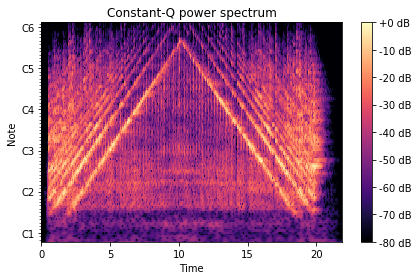

In [43]:
lr.display.specshow(lr.amplitude_to_db(cqtSpect, ref=np.max), \
                    sr=sampleRate, x_axis='time', y_axis='cqt_note', fmin=lr.midi_to_hz(21), bins_per_octave=24)
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [44]:
# lr.display.specshow?

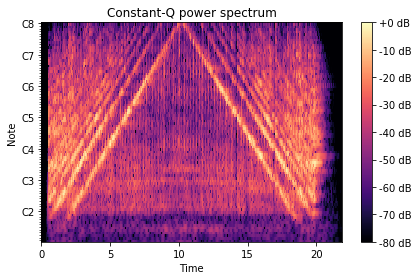

In [45]:
y, sr = lr.load(DATAPOINT)
C = lr.cqt(y, sr=sr)
lr.display.specshow(lr.amplitude_to_db(C, ref=np.max), \
                    sr=sampleRate, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [46]:
C.T.shape

(942, 84)

In [180]:
C.dtype

dtype('complex128')

Generate ground truths:
+ Create ground truth range 
  --> SR from MAPS, Hop Length from...
  --> t = HL/SR
  --> np.arange(Num of Frames (from above)) * t

### STFT + Triangular Filterbank form

In [47]:
signal = mm.audio.signal.Signal(DATAPOINT, num_channels=1)
framedSignal = mm.audio.signal.FramedSignal(signal, frame_size=2048, hop_size=441)

In [48]:
signal.sample_rate

44100

In [166]:
stfttri = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=48,
    num_channels=1, 
    sr=44100,
    unique_filters=True,
    norm_filters=True,
    frame_size=4096,
    fft_size=4096,
    fps=100, # 31.25 trash
    fmin=30,
    fmax=8000.0,
    fref=440.0,
    circular_shift=False,
    hop_size=441.0)

In [167]:
print stfttri.min()
print stfttri.max()

0.0
2.117051


In [168]:
stfttri = np.array(stfttri)
stfttri = lr.util.normalize(stfttri, norm=np.inf)

In [169]:
stfttri

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00478589, 0.00114939, 0.00137545, ..., 0.00030563, 0.00059367,
        0.00077879],
       [0.00127775, 0.00125573, 0.00115828, ..., 0.00029295, 0.00057422,
        0.00072768],
       [0.00096335, 0.00111866, 0.00113437, ..., 0.00022662, 0.00045324,
        0.00056277]])

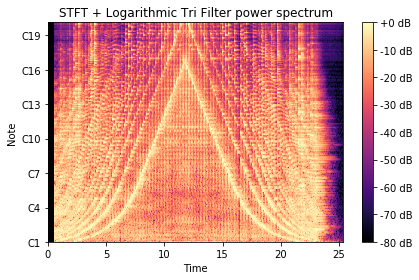

In [170]:
lr.display.specshow(
    lr.amplitude_to_db(stfttri, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

### Generate Ground Truths

For each column in transform
- Reshape.
  - np.abs, rescale to (0 to 1)
- Generate ground truth array
  - Times = np.arange(Nframes) * t
    - Where t = hopLength/sampleRate
  - Use associative .txt to check which pitches are on or off.
  - Output ground truth array with which notes are on or off
    - i.e. [0, 1, 0 , 0 , 0...]

Pad and Create Window

In [171]:
testArray = np.array([[1, 2],[3, 4]])
testArray

array([[1, 2],
       [3, 4]])

In [172]:
np.pad(testArray, ((1, 1), (0, 0)), 'constant')

array([[0, 0],
       [1, 2],
       [3, 4],
       [0, 0]])

(num_of_bins, time_steps)

In [173]:
times = lr.frames_to_time(
    np.arange(stfttri.shape[0]),
    sr=44100,
    hop_length=441.0
)

In [174]:
midi = pm.PrettyMIDI(MIDI_DATAPOINT)

In [175]:
expectedOutput = midi.get_piano_roll(fs=44100, times=times)[21:108+1].T
expectedOutput[expectedOutput > 0] = 1

In [176]:
expectedOutput[expectedOutput > 0] = 1

#### Sanity Check spectrogram + expected:

In [177]:
print stfttri.shape
print expectedOutput.shape
print times.shape

(2186, 229)
(2186, 88)
(2186,)


In [178]:
test_ticks = range(95,95+95)

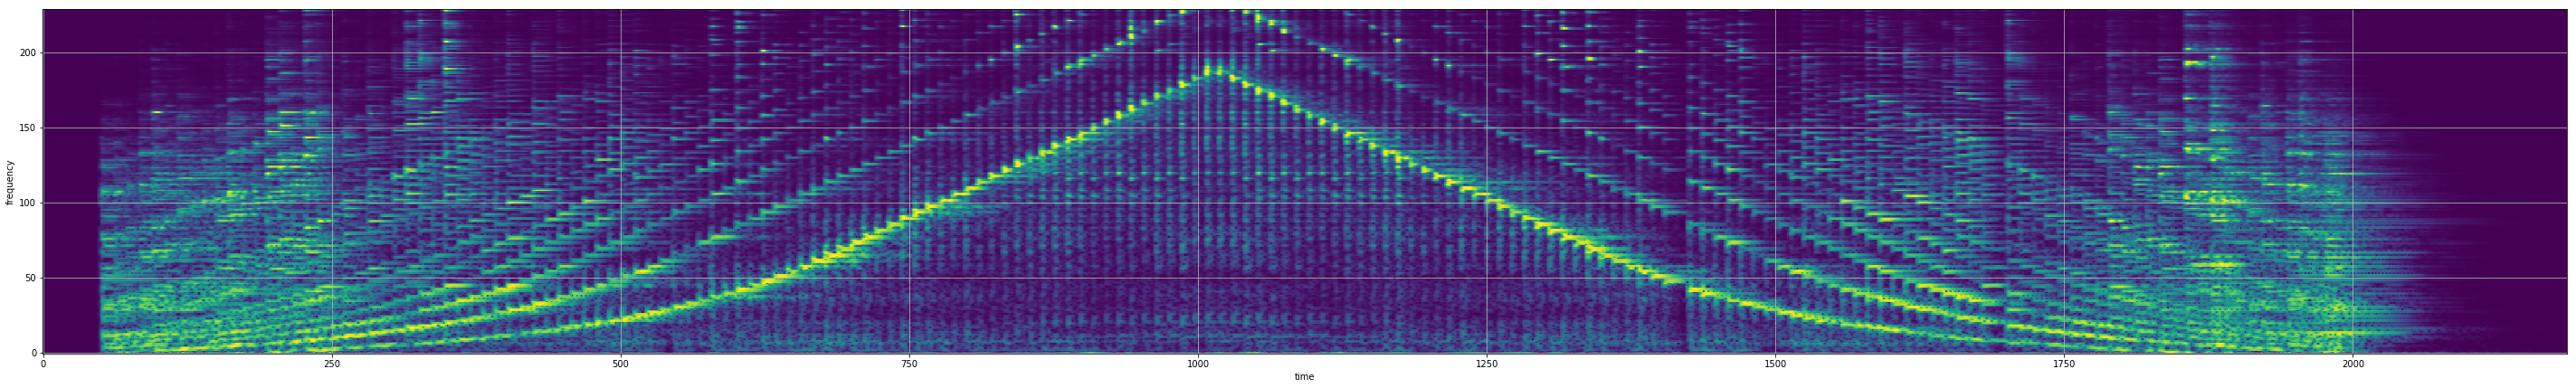

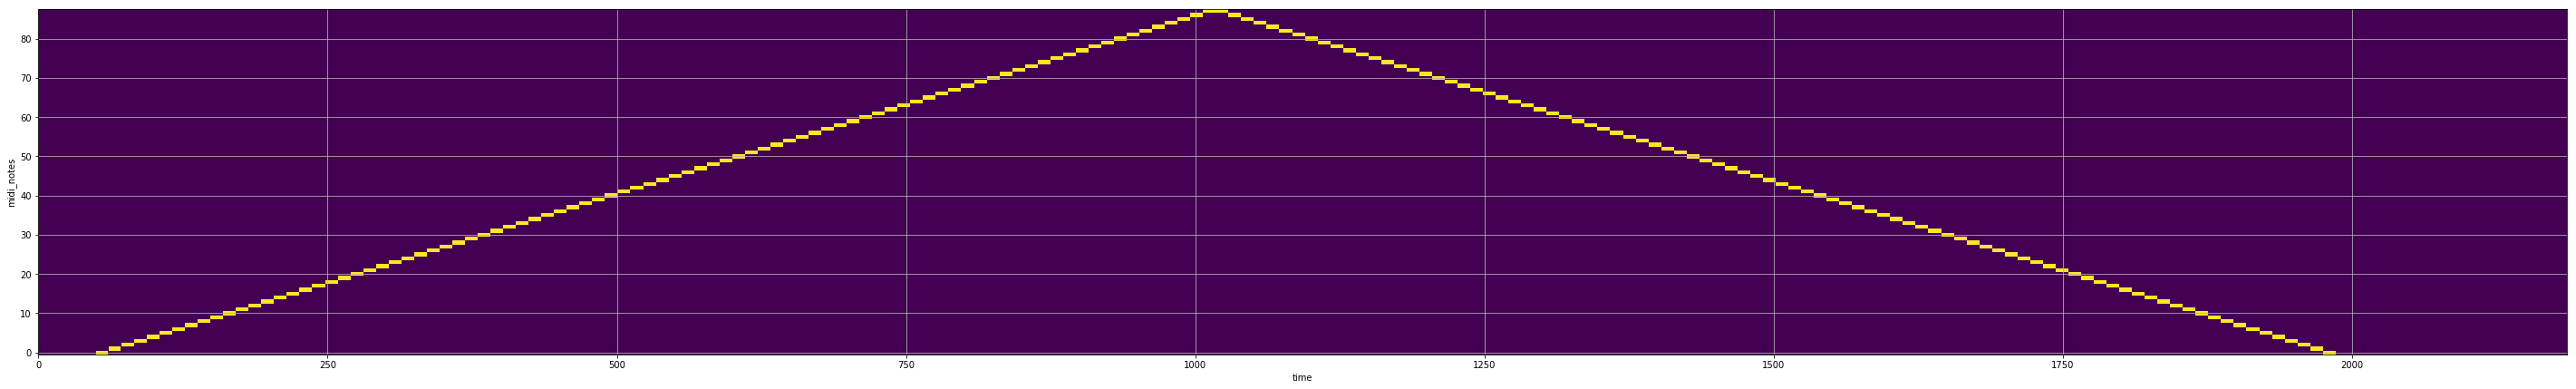

In [179]:
length = 50

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(stfttri.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
# plt.xticks(time_locs, times)
# plt.savefig('spect.png')
plt.show()
fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(expectedOutput.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
# plt.xticks(time_locs, times)
# plt.savefig('ground.png')
plt.show()

## HCQT Form

In [ ]:
def get_hcqt_params():
    """Hack to always use the same parameters :)
    """
    bins_per_octave = 60
    n_octaves = 6
    harmonics = [0.5, 1, 2, 3, 4, 5]
    sr = 22050
    fmin = 32.7
    hop_length = 256
    return bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length

def compute_hcqt(path):
    (bins_per_octave, n_octaves, harmonics,
     sr, f_min, hop_length) = get_hcqt_params()
    
    y, fs = lr.load(path, sr=sr)
    
    cqt_list = []
    shapes = []
    for h in harmonics:
        cqt = lr.cqt(
                y,
                sr=fs,
                hop_length=hop_length,
                fmin=f_min*float(h),
                n_bins=bins_per_octave*n_octaves,
                bins_per_octave=bins_per_octave)
        cqt_list.append(cqt)
        shapes.append(cqt.shape)
    
    shapes_equal = [s == shapes[0] for s in shapes]
    if not all(shapes_equal):
        min_time = np.min([s[1] for s in shapes])
        new_cqt_list = []
        for i in range(len(cqt_list)):
            new_cqt_list.append(cqt_list[i][:, :min_time])
        cqt_list = new_cqt_list
        
    log_hcqt = ((1.0/80.0) * lr.core.amplitude_to_db(
        np.abs(np.array(cqt_list)), ref=np.max)) + 1.0
    return log_hcqt

In [ ]:
log_hcqt = compute_hcqt(DATAPOINT)

In [ ]:
"harmonics, time, frequencies"
log_hcqt.shape

In [ ]:
array = np.array([[1, 2], [1, 2], [1, 2]])
array.shape

'MIN_MIDI' : 21,
'MAX_MIDI' : 108,

In [ ]:
print lr.midi_to_hz(21)
print lr.midi_to_hz(108)
print lr.hz_to_note(lr.midi_to_hz(21))
print lr.hz_to_note(lr.midi_to_hz(108))